In [14]:
import os
import requests
import pandas as pd
from datetime import datetime
import urllib3

# Desactivar warnings de SSL (porque usaremos verify=False)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Carpeta base LOCAL (no usar tu Drive para que el profe pueda reproducir)
BASE_DIR = "/content/emergencias123_u4"
RAW_DIR = os.path.join(BASE_DIR, "raw")

os.makedirs(RAW_DIR, exist_ok=True)

BASE_DIR, RAW_DIR


('/content/emergencias123_u4', '/content/emergencias123_u4/raw')

In [15]:
# Endpoint de CKAN
PACKAGE_URL = "https://datosabiertos.bogota.gov.co/api/3/action/package_show"

# Nombre del dataset en CKAN (id)
DATASET_NAME = "llamadas-de-urgencias-y-emergencias-que-ingresan-a-traves-de-la-linea-123"

# Llamado al API (verify=False por temas de certificado)
resp = requests.get(PACKAGE_URL, params={"id": DATASET_NAME}, verify=False)
package = resp.json()

if not package.get("success", False):
    raise RuntimeError("No se pudo obtener el paquete CKAN. Revisa el nombre del dataset.")

resources = package["result"]["resources"]
print("Total recursos encontrados:", len(resources))

# Mostrar algunos para verificar
for r in resources[:5]:
    print("-", r.get("name"), "=>", r.get("id"))


Total recursos encontrados: 79
- LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD OCTUBRE 2025. => 9b5c7c88-7176-47fa-b82f-f03c5af26594
- METADATO LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 => 3d9813d6-897e-4ea8-a891-7514106bf180
- LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD SEPTIEMBRE 2025. => 8271e353-b9ba-497a-acbc-3c92d3edd52e
- LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD AGOSTO 2025. => d164dfcc-add8-4f3a-8f55-d10e0ab6bed3
- LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD JULIO 2025. => fa221f24-593a-4d3c-b697-e2f42ccbb314


In [16]:
# Definimos meses válidos en español
MESES_MAP = {
    "ENERO": 1,
    "FEBRERO": 2,
    "MARZO": 3,
    "ABRIL": 4,
    "MAYO": 5,
    "JUNIO": 6,
    "JULIO": 7,
    "AGOSTO": 8,
    "SEPTIEMBRE": 9,
    "OCTUBRE": 10,
    "NOVIEMBRE": 11,
    "DICIEMBRE": 12,
}

def parse_fecha_desde_nombre(nombre: str) -> datetime:
    """
    Intenta extraer mes y año del nombre del recurso.
    Ejemplo: 'LLAMADAS DE URGENCIAS ... SALUD SEPTIEMBRE 2025.'
    """
    nombre_up = nombre.upper()
    partes = nombre_up.replace(".", " ").split()

    mes = None
    anio = None

    for p in partes:
        if p in MESES_MAP:
            mes = MESES_MAP[p]
        if p.isdigit() and len(p) == 4:
            anio = int(p)

    if mes and anio:
        return datetime(anio, mes, 1)
    # Si no se pudo parsear, devolver algo muy viejo para no dañar el orden
    return datetime(1900, 1, 1)

# Filtrar SOLO recursos mensuales de SALUD (ignoramos cosas viejas/otros tipos)
recursos_mensuales = []
for r in resources:
    nombre = r.get("name", "")
    rid = r.get("id", "")
    nombre_up = nombre.upper()

    # criterio simple: que el nombre contenga "SALUD" y un mes válido
    if "SALUD" in nombre_up and any(m in nombre_up for m in MESES_MAP.keys()):
        recursos_mensuales.append((nombre, rid))

print("Recursos mensuales detectados:", len(recursos_mensuales))
for n, rid in recursos_mensuales[:10]:
    print(n, "=>", rid)

# Ordenar por fecha (descendente) y tomar los 12 más recientes
recursos_ordenados = sorted(
    recursos_mensuales,
    key=lambda x: parse_fecha_desde_nombre(x[0]),
    reverse=True
)

recursos_12m = recursos_ordenados[:12]

print("\n📅 Últimos 12 meses detectados:")
for n, rid in recursos_12m:
    print(n, "=>", rid)


Recursos mensuales detectados: 74
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD OCTUBRE 2025. => 9b5c7c88-7176-47fa-b82f-f03c5af26594
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD SEPTIEMBRE 2025. => 8271e353-b9ba-497a-acbc-3c92d3edd52e
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD AGOSTO 2025. => d164dfcc-add8-4f3a-8f55-d10e0ab6bed3
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD JULIO 2025. => fa221f24-593a-4d3c-b697-e2f42ccbb314
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD JUNIO 2025 => 15b8faf8-60e3-451a-98bc-090b69411698
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD MAYO 2025 => a71dc0c9-6d38-4bcf-964d-7eea5b24aeb1
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD ABRIL 2025 => 9867ba1a-bd16-41b0-97f1-52156d4fdf32
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD MARZO 2025 => f9e22870-ae80-4a3b-98a7-05e3de90435c
LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD FEBRERO 2025 => 75bfeee8-abfe-4505-83f4-cdc1cba62fca
LLAMADAS

In [17]:
API_DATASTORE_URL = "https://datosabiertos.bogota.gov.co/api/3/action/datastore_search"

dfs = []

for nombre, rid in recursos_12m:
    print(f"\n⬇️ Descargando mes: {nombre} (resource_id={rid})")

    offset = 0
    limit = 50000
    all_records = []

    while True:
        params = {
            "resource_id": rid,
            "limit": limit,
            "offset": offset
        }

        resp = requests.get(API_DATASTORE_URL, params=params, verify=False)
        data = resp.json()

        if not data.get("success", False):
            print("⚠️  Problema con resource_id:", rid)
            break

        records = data["result"]["records"]
        if not records:
            break

        all_records.extend(records)
        offset += limit
        print(f"   Registros acumulados: {len(all_records)}", end="\r")

    print(f"\n   ✅ Total registros mes '{nombre}': {len(all_records)}")

    df_mes = pd.DataFrame(all_records)
    df_mes["mes_origen"] = nombre  # etiqueta útil
    dfs.append(df_mes)

# Consolidar todo en un solo DataFrame
df_raw = pd.concat(dfs, ignore_index=True)
print("\n📊 Total filas consolidadas (12 meses):", len(df_raw))
print("Columnas detectadas:")
print(df_raw.columns.tolist())

df_raw.head()



⬇️ Descargando mes: LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD OCTUBRE 2025. (resource_id=9b5c7c88-7176-47fa-b82f-f03c5af26594)

   ✅ Total registros mes 'LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD OCTUBRE 2025.': 11008

⬇️ Descargando mes: LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD SEPTIEMBRE 2025. (resource_id=8271e353-b9ba-497a-acbc-3c92d3edd52e)

   ✅ Total registros mes 'LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD SEPTIEMBRE 2025.': 11433

⬇️ Descargando mes: LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD AGOSTO 2025. (resource_id=d164dfcc-add8-4f3a-8f55-d10e0ab6bed3)

   ✅ Total registros mes 'LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD AGOSTO 2025.': 10603

⬇️ Descargando mes: LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD JULIO 2025. (resource_id=fa221f24-593a-4d3c-b697-e2f42ccbb314)

   ✅ Total registros mes 'LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 - SALUD JULIO 2025.': 9868

⬇️ Descargando mes: LLAMADAS

,_id,NUMERO_INCIDENTE,FECHA_INICIO_DESPLAZAMIENTO_MOVIL,CODIGO_LOCALIDAD,LOCALIDAD,EDAD,UNIDAD,GENERO,TIPO_INCIDENTE,PRIORIDAD_FINAL,RECEPCION,mes_origen,FECHA_INICIO_DESPLAZAMIENTO_MOVIl,PRIORIDAD FINAL
0,1,CRU-00522381-25,2025-10-01 02:50:09,14,LOS MµRTIRES,23,A§os,FEMENINO,ACOMPA•AMIENTO A EVENTO,Baja,None,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN
1,2,CRU-00522381-25,2025-10-01 00:04:24,14,LOS MµRTIRES,N/A,N/A,N/A,ACOMPA•AMIENTO A EVENTO,Baja,None,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN
2,3,CRU-00522382-25,2025-10-01 00:14:19,9,FONTIB‡N,23,A§os,FEMENINO,PATGIN - PATOLOG÷A GINECOBSTêTRICA,Critica,2025-10-01 02:38:04,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN
3,4,CRU-00522388-25,2025-10-01 00:46:30,1,USAQUêN,86,A§os,FEMENINO,EVERES - EVENTO RESPIRATORIO,Alta,2025-10-01 04:53:42,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN
4,5,CRU-00522391-25,2025-10-01 00:41:05,10,ENGATIVµ,N/A,N/A,N/A,ACOMPA•AMIENTO A EVENTO,Baja,None,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN


In [18]:
df = df_raw.copy()

# Ver qué columnas llegan, para decidir el renombre
print("Columnas originales:")
print(df.columns.tolist())

# Mapeo condicional: solo se renombra si la columna existe
rename_map = {}

if "NUMERO_INCIDENTE" in df.columns:
    rename_map["NUMERO_INCIDENTE"] = "numero_incidente"

# En la API suele venir en minúsculas, pero por seguridad probamos ambas
if "fecha_inicio_desplazamiento_movil" in df.columns:
    rename_map["fecha_inicio_desplazamiento_movil"] = "fecha_inicio_desplazamiento_movil"
elif "FECHA_INICIO_DESPLAZAMIENTO_MOVIL" in df.columns:
    rename_map["FECHA_INICIO_DESPLAZAMIENTO_MOVIL"] = "fecha_inicio_desplazamiento_movil"

if "CODIGO_LOCALIDAD" in df.columns:
    rename_map["CODIGO_LOCALIDAD"] = "codigo_localidad"
if "LOCALIDAD" in df.columns:
    rename_map["LOCALIDAD"] = "localidad"
if "EDAD" in df.columns:
    rename_map["EDAD"] = "edad"
if "UNIDAD" in df.columns:
    rename_map["UNIDAD"] = "unidad"
if "GENERO" in df.columns:
    rename_map["GENERO"] = "genero"
if "TIPO_INCIDENTE" in df.columns:
    rename_map["TIPO_INCIDENTE"] = "tipo_incidente"
if "PRIORIDAD_FINAL" in df.columns:
    rename_map["PRIORIDAD_FINAL"] = "prioridad_final"
if "RECEPCION" in df.columns:
    rename_map["RECEPCION"] = "recepcion"

df = df.rename(columns=rename_map)

# Convertir fecha a datetime si existe
if "fecha_inicio_desplazamiento_movil" in df.columns:
    df["fecha_inicio_desplazamiento_movil"] = pd.to_datetime(
        df["fecha_inicio_desplazamiento_movil"], errors="coerce"
    )

# Crear columnas de año y mes útiles para U4
if "fecha_inicio_desplazamiento_movil" in df.columns:
    df["anio"] = df["fecha_inicio_desplazamiento_movil"].dt.year
    df["mes"] = df["fecha_inicio_desplazamiento_movil"].dt.month

print("\nColumnas después de normalizar:")
print(df.columns.tolist())

df[["numero_incidente","fecha_inicio_desplazamiento_movil","localidad","tipo_incidente","prioridad_final"]].head()


Columnas originales:
['_id', 'NUMERO_INCIDENTE', 'FECHA_INICIO_DESPLAZAMIENTO_MOVIL', 'CODIGO_LOCALIDAD', 'LOCALIDAD', 'EDAD', 'UNIDAD', 'GENERO', 'TIPO_INCIDENTE', 'PRIORIDAD_FINAL', 'RECEPCION', 'mes_origen', 'FECHA_INICIO_DESPLAZAMIENTO_MOVIl', 'PRIORIDAD FINAL']

Columnas después de normalizar:
['_id', 'numero_incidente', 'fecha_inicio_desplazamiento_movil', 'codigo_localidad', 'localidad', 'edad', 'unidad', 'genero', 'tipo_incidente', 'prioridad_final', 'recepcion', 'mes_origen', 'FECHA_INICIO_DESPLAZAMIENTO_MOVIl', 'PRIORIDAD FINAL', 'anio', 'mes']


,numero_incidente,fecha_inicio_desplazamiento_movil,localidad,tipo_incidente,prioridad_final
0,CRU-00522381-25,2025-10-01 02:50:09,LOS MµRTIRES,ACOMPA•AMIENTO A EVENTO,Baja
1,CRU-00522381-25,2025-10-01 00:04:24,LOS MµRTIRES,ACOMPA•AMIENTO A EVENTO,Baja
2,CRU-00522382-25,2025-10-01 00:14:19,FONTIB‡N,PATGIN - PATOLOG÷A GINECOBSTêTRICA,Critica
3,CRU-00522388-25,2025-10-01 00:46:30,USAQUêN,EVERES - EVENTO RESPIRATORIO,Alta
4,CRU-00522391-25,2025-10-01 00:41:05,ENGATIVµ,ACOMPA•AMIENTO A EVENTO,Baja


In [19]:
csv_salida = os.path.join(RAW_DIR, "emergencias_123_12meses_normalizado.csv")
df.to_csv(csv_salida, index=False, encoding="utf-8")

print("✅ Dataset final para U4 guardado en:")
print(csv_salida)
print("Filas:", len(df))


✅ Dataset final para U4 guardado en:
/content/emergencias123_u4/raw/emergencias_123_12meses_normalizado.csv
Filas: 129650


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset generado en U3
df = pd.read_csv("/content/emergencias123_u4/raw/emergencias_123_12meses_normalizado.csv")

df.head()

/tmp/ipython-input-3941687298.py:5: DtypeWarning: Columns (5,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/emergencias123_u4/raw/emergencias_123_12meses_normalizado.csv")


,_id,numero_incidente,fecha_inicio_desplazamiento_movil,codigo_localidad,localidad,edad,unidad,genero,tipo_incidente,prioridad_final,recepcion,mes_origen,FECHA_INICIO_DESPLAZAMIENTO_MOVIl,PRIORIDAD FINAL,anio,mes
0,1,CRU-00522381-25,2025-10-01 02:50:09,14,LOS MµRTIRES,23.0,A§os,FEMENINO,ACOMPA•AMIENTO A EVENTO,Baja,NaN,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN,2025.0,10.0
1,2,CRU-00522381-25,2025-10-01 00:04:24,14,LOS MµRTIRES,NaN,NaN,NaN,ACOMPA•AMIENTO A EVENTO,Baja,NaN,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN,2025.0,10.0
2,3,CRU-00522382-25,2025-10-01 00:14:19,9,FONTIB‡N,23.0,A§os,FEMENINO,PATGIN - PATOLOG÷A GINECOBSTêTRICA,Critica,2025-10-01 02:38:04,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN,2025.0,10.0
3,4,CRU-00522388-25,2025-10-01 00:46:30,1,USAQUêN,86.0,A§os,FEMENINO,EVERES - EVENTO RESPIRATORIO,Alta,2025-10-01 04:53:42,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN,2025.0,10.0
4,5,CRU-00522391-25,2025-10-01 00:41:05,10,ENGATIVµ,NaN,NaN,NaN,ACOMPA•AMIENTO A EVENTO,Baja,NaN,LLAMADAS DE URGENCIAS Y EMERGENCIAS LINEA 123 ...,NaN,NaN,2025.0,10.0


In [21]:
# Asegurar columnas necesarias
df["anio"] = df["anio"].fillna(0).astype(int)
df["mes"] = df["mes"].fillna(0).astype(int)

df_temporal = df.groupby(["anio","mes"]).size().reset_index(name="llamadas")

df_localidad = df["localidad"].value_counts().head(10)

df_tipos = df["tipo_incidente"].value_counts().head(10)

df_prioridad = df["prioridad_final"].value_counts()

if "genero" in df.columns:
    df_genero = df["genero"].value_counts()
else:
    df_genero = None


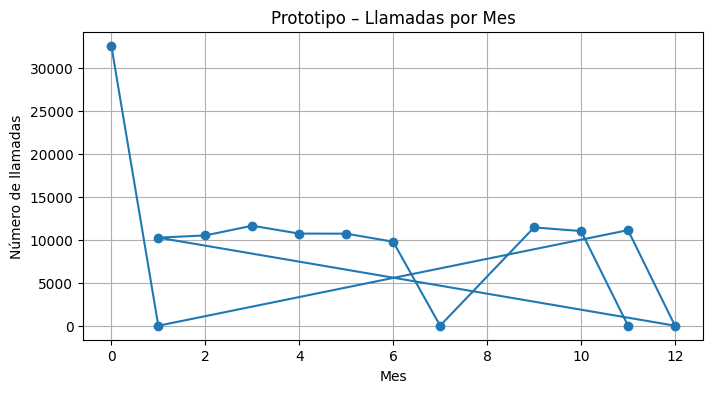

In [22]:
plt.figure(figsize=(8,4))
plt.plot(df_temporal["mes"], df_temporal["llamadas"], marker="o")
plt.title("Prototipo – Llamadas por Mes")
plt.xlabel("Mes")
plt.ylabel("Número de llamadas")
plt.grid(True)
plt.show()

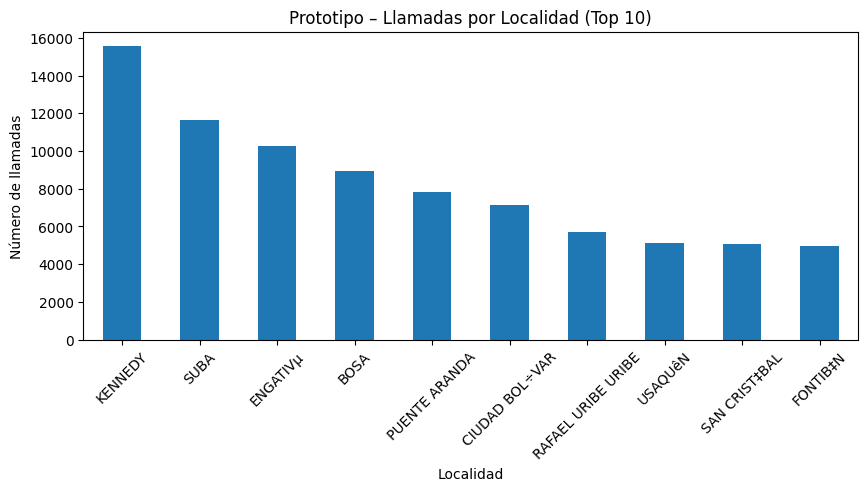

In [23]:
plt.figure(figsize=(10,4))
df_localidad.plot(kind="bar")
plt.title("Prototipo – Llamadas por Localidad (Top 10)")
plt.xlabel("Localidad")
plt.ylabel("Número de llamadas")
plt.xticks(rotation=45)
plt.show()


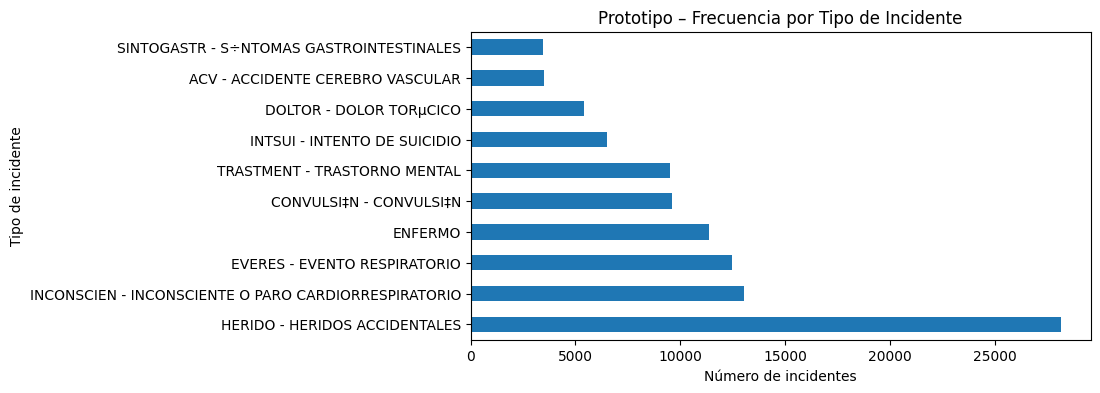

In [24]:
plt.figure(figsize=(8,4))
df_tipos.plot(kind="barh")
plt.title("Prototipo – Frecuencia por Tipo de Incidente")
plt.xlabel("Número de incidentes")
plt.ylabel("Tipo de incidente")
plt.show()


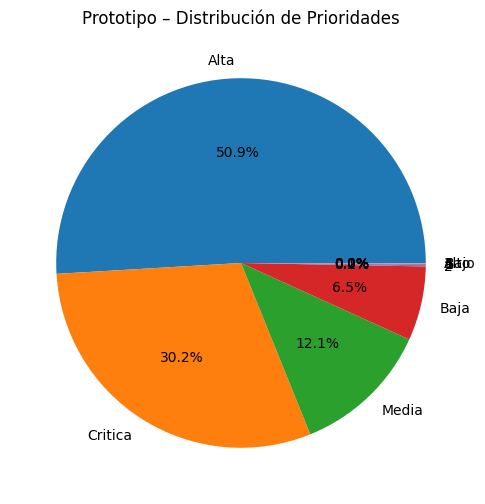

In [25]:
plt.figure(figsize=(6,6))
plt.pie(df_prioridad, labels=df_prioridad.index, autopct="%1.1f%%")
plt.title("Prototipo – Distribución de Prioridades")
plt.show()


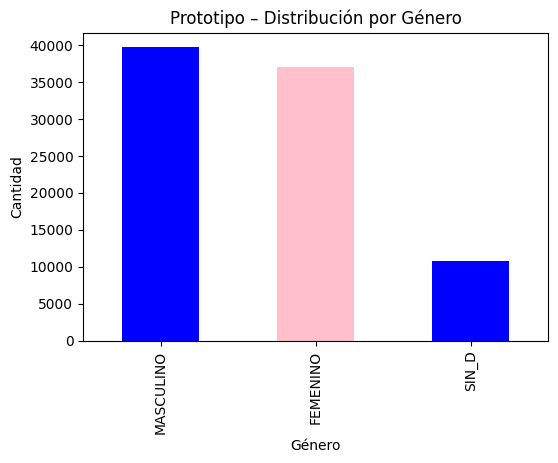

In [26]:
if df_genero is not None:
    plt.figure(figsize=(6,4))
    df_genero.plot(kind="bar", color=["blue","pink"])
    plt.title("Prototipo – Distribución por Género")
    plt.xlabel("Género")
    plt.ylabel("Cantidad")
    plt.show()
else:
    print("No existe columna de género para este prototipo.")


1. Análisis Temporal – Gráfico de Línea

El gráfico de línea es ideal para representar las variaciones de llamadas a lo largo del tiempo, permitiendo identificar tendencias, picos de demanda, interrupciones del servicio y estacionalidades mensuales. Es la mejor opción para series temporales.

2. Análisis Geográfico – Barras por Localidad

Aunque el dashboard final tendrá un mapa interactivo, para el prototipo las barras permiten comparar rápidamente cuáles localidades concentran la mayor cantidad de emergencias. Es una visualización clara y directa para validación temprana.

3. Clasificación – Barras Horizontales (Tipos de incidente)

Dado que los tipos de incidente suelen tener nombres largos, las barras horizontales mejoran la legibilidad y facilitan la comparación entre categorías. Esta visualización se usará luego en el dashboard interactivo.

4. Eficiencia Operacional – Pie Chart (Prioridad final)

Como prototipo, el pie chart sirve para validar la proporción de prioridades asignadas. El dashboard final utilizará un gráfico más robusto (barras o sunburst), pero esta primera visualización permite validar la narrativa.

5. Análisis Demográfico – Barras por Género

Si el dataset contiene género, una barra simple permite comparar proporciones de atención entre categorías (masculino, femenino, sin dato). Este tipo de gráfica es clara y adecuada para variables categóricas simples.